# Ising ground state with iTEBD (using Matrix Product States)

**Preliminaries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats

In [2]:
Sz = np.array( [[1,0],[0,-1]] )
Sx = np.array( [[0,1],[1,0]] )
Sy = np.array( [[0,-1j],[1j,0]] )
Id = np.eye(2)
H = np.array( [[1,1],[1,-1]] )/np.sqrt(2)

In [3]:
SVD_THRESHOLD = 10**-12
def svd_chop(M, max_chi = None, svd_threshold = None, full_matrices=False):
    if svd_threshold is None: svd_threshold = SVD_THRESHOLD
    u,s,v = np.linalg.svd(M, full_matrices=full_matrices)
    to_chop = np.where(s < svd_threshold)[0]
    if (not full_matrices) and (len(to_chop)>0 or ((max_chi is not None) and (max_chi < len(s)))):
        if len(to_chop)>0 and max_chi is not None:
            chop_idx = min(to_chop[0],max_chi)
        elif len(to_chop)>0:
            chop_idx = to_chop[0]
        else:
            chop_idx = max_chi
        u = u[:,:chop_idx]
        s = s[:chop_idx]
        v = v[:chop_idx,:]
    #print(u,s,v)
    return u,s,v

def to_real_safe(m):
    if (np.abs(np.imag(m)) > 10**-12).any():
        raise ValueError
    return np.real(m)

**Creating the "Matrix Product State" class**

A class is a new type of variable that you can create, which can come with functions that you write to act on it, etc.

Here we have a class for Matrix Product State objects, which has the following functions, among others:
- ```init_from_product_state(state, basis)```: state is a list of 0 and 1, and basis can be '+z', '+x', or 'random'.  'random' will use a random initial spin on each site
- ```copy()```: creates a copy, which can be modified without modifying the original
- ```print_summary()```: prints some data about the state
- ```overlap(psi2)```: finds <psi2|psi>
- ```normalize()```: normalizes the wave function
- ```apply_one_site_op(op,site)```: applies an operator (eg Sx) on the specified site
- ```apply_two_site_op(op,site1)```: applies a two-site operator (eg Sz $\otimes$ Sz) on site1 and site1+1
- ```one_site_expec_val(op, site)```: finds the expectation value of ```op``` on site ```site```
- ```correlation_function(op1, op2, site1, site2)```: finds <op1_site1 op2_site2>
- ```measure_one_site_op(op, profile=False)```: finds the expectation value of op on every site.  If profile is False, returns the mean.  If it's true, also returns the individual values
- ```measure_two_site_op(op, profile=False)```: finds the expectation value of op on every pair of adjacent sites.  If profile is False, returns the mean.  If it's true, also returns the individual values

Further details about the arguments for these functions and what they return can be found in the comments for each function

In [4]:
class MPS():
    
    def __init__(self):
        self.N = 0
        self.tensors = None
        self.chis = None
        self.ortho_center = np.nan
        
    @classmethod
    def init_from_product_state(cls, state, basis = '+z'):
        """
        Input: a list of the form [0,1,1,0,0,1, ...] with N elements
        If 'basis' is:
            '+z', this is interpreted as 0 -> spin up, 1 -> spin down
            '+x', this is interpreted as 0 -> spin right, 1 -> spin left
            'random', generates a random unitary for each spin, giving a totally random initial product state
            
        Output: an MPS object representing this product state, with bond dimension 1
        """
        psi = cls()
        psi.N = len(state)
        psi.tensors = [ np.array( [ [[ 1-state[i] ]], [[ state[i] ]] ] ) for i in range(psi.N) ] 
        psi.chis = [1] * (psi.N - 1) # bond 0 is between site 0 and site 1, etc
        psi.ortho_center = 0
        
        if basis == '+z':
            pass # do nothing
        elif basis == '+x':
            psi.tensors = [ np.tensordot(H,T,axes=[[1],[0]]) for T in psi.tensors ]
        elif basis == 'random':
            psi.tensors = [ np.tensordot(sp.stats.unitary_group.rvs(2),T,axes = [[1],[0]]) for T in psi.tensors ]
        else:
            raise ValueError("Specified basis not implemented")
            
        return psi
    
    def copy(self):
        """
        Makes a deep copy that can be modified without modifying self
        """
        psi = MPS()
        psi.N = self.N
        psi.tensors = [t.copy() for t in self.tensors]
        psi.chis = self.chis.copy()
        psi.ortho_center = self.ortho_center
        return psi
    
    def move_ortho_center(self, new_center, max_bond_dim = None):
        """
        Moves the orthogonality center of the MPS to the specified location
        """
        if self.ortho_center is None or self.ortho_center < new_center:
            start = 0 if self.ortho_center is None else self.ortho_center
            for site in range(start,new_center):
                A, B = self.tensors[site], self.tensors[site+1]
                dims = A.shape
                to_svd = np.reshape(A, (dims[0]*dims[1],dims[2]))
                u,d,v = svd_chop(to_svd, max_chi = max_bond_dim)
                self.chis[site] = len(d)
                self.tensors[site] = np.reshape( u, (dims[0],dims[1],self.chis[site]) )
                self.tensors[site+1] = np.tensordot( B, np.diag(d)@v, axes=[[1],[1]]).transpose(0,2,1)
                
        if self.ortho_center is None or self.ortho_center > new_center:
            start = self.N - 1 if self.ortho_center is None else self.ortho_center
            for site in range(start, new_center, -1):
                A, B = self.tensors[site-1], self.tensors[site]
                dims = B.shape
                to_svd = np.reshape(B.transpose(1,0,2), (dims[1],dims[0]*dims[2]))
                u,d,v = svd_chop(to_svd, max_chi = max_bond_dim)
                self.chis[site-1] = len(d)
                self.tensors[site] = np.reshape( v, (self.chis[site-1],dims[0],dims[2]) ).transpose(1,0,2)
                self.tensors[site-1] = np.tensordot( A, u@np.diag(d), axes=[[2],[0]])
            
        self.ortho_center = new_center
        
    def print_summary(self):
        print(" Psi summary:")
        print(" Length:", self.N)
        print(" Bond dimensions:", self.chis)
        print(" Tensor dimensiosn:")
        for t in self.tensors:
            print("  ", t.shape)
        print(" Ortho center:", self.ortho_center)
        
    def test_ortho_center(self):
        if self.ortho_center is None:
            print("ortho_center is None")
            return False
        all_correct = True
        for site in range(self.ortho_center):
            t = self.tensors[site]
            _, left_chi, right_chi = t.shape
            contracted = np.tensordot(np.eye(left_chi), t, axes = [[0],[1]])
            contracted = np.tensordot(contracted, t.conj(), axes = [[0,1],[1,0]])
            err = np.linalg.norm(contracted - np.eye(right_chi))
            if err > 10**-12:
                print("Error on site", site)
                all_correct = False
        for site in range(self.N - 1, self.ortho_center, -1):
            t = self.tensors[site]
            _, left_chi, right_chi = t.shape
            contracted = np.tensordot(np.eye(right_chi), t, axes = [[0],[2]])
            contracted = np.tensordot(contracted, t.conj(), axes = [[0,1],[2,0]])
            err = np.linalg.norm(contracted - np.eye(left_chi))
            if err > 10**-12:
                print("Error on site", site)
                all_correct = False
        return all_correct
        
    def overlap(self, psi2):
        """
        Returns <psi2 | self>
        """
        if psi2 is None: psi2 = self
        assert self.N == psi2.N
        contracted = np.ones( (1,1) )
        for site in range(self.N):
            contracted = np.tensordot(contracted, self.tensors[site], axes = [[0],[1]])
            contracted = np.tensordot(contracted, psi2.tensors[site].conj(), axes = [[0,1],[1,0]])
        contracted = np.trace(contracted)
        return contracted
    
    def normalize(self):
        if self.ortho_center is None:
            norm_square = self.overlap(self)
            self.tensors = [t/norm_square**(1/(2*self.N)) for t in self.tensors]
        else:
            oc = self.ortho_center
            norm = np.sqrt(np.tensordot(self.tensors[oc],self.tensors[oc].conj(),axes=[[0,1,2],[0,1,2]]))
            self.tensors[oc] /= norm
    
    def apply_one_site_op(self, op, site):
        """
        Applies a one-site operator, eg Sz, at the specified site
        Modifies self, does not return a copy
        op should be a 2 x 2 matrix, with index 1 to be contracted with the
            physical leg of the tensor in self
        """
        self.tensors[site] = np.tensordot(op, self.tensors[site], axes = [[1],[0]])
        
    def apply_two_site_op(self, op, site1, sweep_direction = None, max_bond_dimension = None):
        """
        Applies a two-site operator, eg Sz Sz, on site1 and site1+1
        Modifies self, does not return a copy
        op should be a 2x2x2x2 tensor:
            index 1 will be contracted with the physical leg on site1
            index 0 will be the new physical leg on site1
            index 3 will be contracted with the physical leg on site1+1
            index 2 will be the new physical leg on site1+1
        sweep_direction can be 'r','l', or None:
            'r' will truncate the bond with singular values sent to the right tensor
            'l' will truncate the bond with singular values sent to the left tensor
            None defaults to 'r'
        max_bond_dimension is the max allowed bond dimension on the bond after applying the operator and truncating
        """
        if sweep_direction not in ['l','r',None]: raise ValueError("Invalid sweep direction")
        if sweep_direction is None: sweep_direction = 'r'
        if sweep_direction == 'r':
            self.move_ortho_center(site1)
        else:
            self.move_ortho_center(site1+1)
        
        A, B = self.tensors[site1], self.tensors[site1+1]
        theta = np.tensordot(A,B, axes = [[2],[1]]).transpose(0,2,1,3)
        theta = np.tensordot(op, theta, axes = [[1,3],[0,1]])
        dims = theta.shape
        to_svd = theta.transpose(0,2,1,3).reshape(dims[0]*dims[2],dims[1]*dims[3])
        u,d,v = svd_chop(to_svd, max_chi = max_bond_dimension)
        if sweep_direction == 'r':
            v = np.diag(d) @ v
        else:
            u = u @ np.diag(d)
        chi = self.chis[site1] = len(d)
        u = u.reshape(dims[0],dims[2],chi)
        v = v.reshape(chi,dims[1],dims[3]).transpose(1,0,2)
        self.tensors[site1] = u
        self.tensors[site1+1] = v
        if sweep_direction == 'r':
            self.ortho_center += 1
        else:
            self.ortho_center -= 1
            
    def one_site_expec_val(self, op, site):
        """
        Finds the expectation value of op on the specified site
        op should be a 2x2 tensor: index 0 for the row, 1 for the columns
        """
        self.move_ortho_center(site)
        contracted = np.tensordot(op, self.tensors[site], axes=[[1],[0]])
        contracted = np.tensordot(op, self.tensors[site].conj(), axes = [[0,1,2],[0,1,2]])
        return contracted
    
    def correlation_function(self, op1, op2, site1, site2):
        """
        Finds the correlation function for op1 on site1 and op2 on site2
        Each of op1 and op2 should be a 2x2 tensor: index 0 for the row, 1 for the columns
        """
        psi = self.copy()
        psi.apply_one_site_op(op1, site1)
        psi.apply_one_site_op(op2, site2)
        return self.overlap(psi)
            
    def measure_one_site_op(self, op, profile = False, sweep_direction = 'r'):
        """
        Finds the expectation value of op on each site, returns the average
        op should be a 2x2 tensor: index 0 for the row, 1 for the columns
        profile can be True or [default] False:
            if False, just returns the average,
            if True, returns the value on each site as well
        sweep_direction determines whether the expectation value calculation
            start with the leftmost site ('r') or rightmost ('l')
        """
        site_vals = np.zeros(self.N, dtype = np.complex)
        
        if sweep_direction == 'r':
            sites = range(self.N)
        elif sweep_direction == 'l':
            sites = range(self.N-1,-1,-1)
        else:
            raise ValueError("Invalid sweep direction")
            
        for i in sites:
            self.move_ortho_center(i)
            op_applied = np.tensordot(op,self.tensors[i],axes=[[1],[0]])
            site_vals[i] = np.tensordot(op_applied,self.tensors[i].conj(), axes=[[0,1,2],[0,1,2]])
            
        if all(np.abs(np.imag(site_vals))) < 10**-12:
            site_vals = np.real(site_vals)
            
        avg_val = np.mean(site_vals)
        if profile:
            return avg_val, site_vals
        return avg_val
    
    def measure_two_site_op(self, op, profile = False, sweep_direction = 'r'):
        """
        Finds the expectation value of a two-site operator on each pair of 
            adjacent sites, returns the average
        op should be a 2x2x2x2 tensor: 
            index 1 will be contracted with the physical leg on site1
            index 0 will be the new physical leg on site1
            index 3 will be contracted with the physical leg on site1+1
            index 2 will be the new physical leg on site1+1
        profile can be True or [default] False:
            if False, just returns the average,
            if True, returns the value on each site as well
        sweep_direction determines whether the expectation value calculation
            start with the leftmost site ('r') or rightmost ('l')
        Assumes nonperiodic boundary conditions
        """
        site_vals = np.zeros(self.N-1, dtype = np.complex)
        
        if sweep_direction == 'r':
            sites = range(self.N-1)
        elif sweep_direction == 'l':
            sites = range(self.N-2,-1,-1)
        else:
            raise ValueError("Invalid sweep direction")
            
        for i in sites:
            self.move_ortho_center(i)
            t0 = self.tensors[i]
            t1 = self.tensors[i+1]
            contracted = np.tensordot(t0,t1,axes=[[2],[1]])
            contracted = np.tensordot(contracted, op, axes = [[0,2],[1,3]])
            contracted = np.tensordot(contracted, t0.conj(), axes = [[0,2],[1,0]])
            contracted = np.tensordot(contracted, t1.conj(), axes = [[0,1,2],[2,0,1]])
            site_vals[i] = contracted
            
        if all(np.abs(np.imag(site_vals))) < 10**-12:
            site_vals = np.real(site_vals)
            
        avg_val = np.mean(site_vals)
        if profile:
            return avg_val, site_vals
        return avg_val

**Functions for running iTEBD**

We repeated apply an approximation of $e^{-\tau H}$ to a random initial state, where $\tau$ is some small parameter.  The end result will have an error which is proportional to $\tau^2$, but the computation time also increase when $\tau$ gets smaller.  As a result, we use an adaptive $\tau$ that starts large (0.1) and becomes smaller as the simulation converges.

We will get out a dictionary that stores the following:
- ```'psi'```: the computed ground state, as an MPS object
- ```'E'```: the computed ground state energy
- ```'num_sweeps'```: the number of computational steps needed to converge
- ```'Es'```: a list containing the energy after each step, so you can see how the convergence happens

In [14]:
def get_exp_ZZ(t):
    """
    Returns e^(t * Sz \otimes Sz), in the following form:
        2x2x2x2 tensor, site 1 row index is 0, col index is 1
                        site 2 row index is 2, col index is 3
    """
    ZZ = np.diag(np.exp([t,-t,-t,t]))
    ZZ = ZZ.reshape(2,2,2,2).transpose(0,2,1,3)
    return ZZ

def get_exp_X(t):
    """
    Returns e^(t * Sx), in the following form:
        2x2 tensor, row index is 0, col index is 1
    """
    X = np.array( [[np.cosh(t),np.sinh(t)],[np.sinh(t),np.cosh(t)]])
    return X

def measure_Ising_E(psi, g):
    """
    Given an MPS wavefunction and the parameter g, returns the energy per site
    """
    ZZ_measure = np.tensordot(Sz,Sz,axes=[[],[]])
    E = psi.measure_two_site_op(ZZ_measure)*(psi.N-1)
    E += g*psi.measure_one_site_op(Sx, sweep_direction='l')*psi.N
    return -E/psi.N
            
def Ising_iTEBD(N, g, max_bond_dim, initial_state = None, imag_time_step_init = 10**-2, max_sweeps = 1000, verbose = 0, E_tol = 10**-8):
    """
    Runs the iTEBD algorithm to find an MPS for the ground state of the Ising 
        model on N sites, with parameter g
    The maximum bond dimension on any bond is given by max_bond_dim
    An initial state may be specified by passing in an MPS object, for example
        an output of MPS.init_from_product_state
        If no initial state is specified, uses a random product state
    
    Returns: psi, an MPS object
    """
    if initial_state is None:
        psi = MPS.init_from_product_state([0]*N, basis='random')
    else:
        psi = initial_state.copy()
    psi.move_ortho_center(0)
    
    imag_time_step = imag_time_step_init
    
    exp_ZZ = get_exp_ZZ(imag_time_step)
    exp_X = get_exp_X(imag_time_step * g)
    
    Es = np.zeros(max_sweeps+1)
    Es[:] = np.nan
    
    Es[0] = to_real_safe(measure_Ising_E(psi, g))
    
    for sweep in range(max_sweeps):
        if verbose > 0: 
            print("Sweep number", sweep)
            print("Step size", imag_time_step)
            print("E =", Es[sweep])
            print()
        
        E_decreased = False
        while not E_decreased:
            psi2 = psi.copy()
            # Sweep right, applying ZZ terms
            for site in range(N-1):
                psi2.apply_two_site_op(exp_ZZ, site, sweep_direction = 'r', max_bond_dimension = max_bond_dim)
            # Sweep left, applying X terms
            for site in range(N-1,-1,-1):
                psi2.apply_one_site_op(exp_X, site)
            psi2.move_ortho_center(0)
            # Normalize
            psi2.normalize()
        
            # Check convergence
            E = to_real_safe(measure_Ising_E(psi2, g))
            if E > Es[sweep]:
                if imag_time_step < np.sqrt(E_tol): 
                    if verbose >= 0: print("Escaping infinite loop")
                    break
                imag_time_step /= 2
            else:
                E_decreased = True
                
        psi = psi2
        Es[sweep+1] = E
        if (Es[sweep] - E) < E_tol and imag_time_step < np.sqrt(E_tol):
            if verbose >= 0: print("Converged")
            break
        if (Es[sweep] - E) < imag_time_step**2:
            imag_time_step /= 1.5
            
    data = {'psi':psi, 'E':E, 'Es':Es[:sweep+2], 'num_sweeps':sweep+1}
    
    return data

**Running the program, finding properties of the ground state**

We now run the above for many different parameters.  We vary ```g```, the parameter in the Hamiltonian, ```N```, the number of spins, and ```chi```, the so-called bond dimension of the MPS wave function.  The bond dimension determines the level of precision of our results, and here a value around 10 or 20 will be sufficient.  (For some state of the art calculations in current research, the needed bond dimensions are more like 10000.)

The calculation time increases linearly with ```N``` and is proportional to the cube of the bond dimension.

In [15]:
def get_expecs_vs_g(Ns = [10,30,100,300], bond_dims = [5,10,20], gs = None, verbose = 0):
    """
    Input: a list of system sizes, a list of bond dimensions (higher means more precise but more computation time),
        number of values of g in the range 0 to 2
    Returns: A table with ground state energy per site, one with <Sx_avg>, and one with <Sz_0 Sz_{N-1}>
    """
    if gs is None:
        num_pts = 21
        gs = np.linspace(0,2,num_pts)
    else:
        num_pts = len(gs)
    
    Es = np.zeros( (len(Ns),len(bond_dims),num_pts) )
    Sx_avg = np.zeros( Es.shape )
    Sz0_SzN = np.zeros( Es.shape )
    for N_idx, N in enumerate(Ns):
        print('N:', N)
        psi = MPS.init_from_product_state([0]*N, basis = 'random')
        for chi_idx, chi in enumerate(bond_dims):
            print('Bond dim:', chi)
            for g_idx, g in enumerate(gs):
                if verbose > 0:
                    print('g:', g)
                d = Ising_iTEBD(N, g, chi, initial_state=psi, verbose = verbose-1)
                # Some other options for the line above to get more accurate results at the cost of slower computation:
                #    imag_time_step_init = 10**-3
                #    max_sweeps = 1000 #(or even more)
                Es[N_idx, chi_idx, g_idx] = d['E']
                psi = d['psi']
                Sz0_SzN[N_idx, chi_idx, g_idx] = to_real_safe(psi.correlation_function(Sz, Sz, 0, N-1))
                Sx_avg[N_idx, chi_idx, g_idx] = to_real_safe(psi.measure_one_site_op(Sx))
        print()
    
    return Es, Sx_avg, Sz0_SzN

In [17]:
Ns = [2,5,10,20,50,100]
bond_dims = [5,10,20]
num_pts = 21
gs = np.linspace(0,2,num_pts)

E, X, ZZ = get_expecs_vs_g(Ns, bond_dims, gs)

N: 2
Bond dim: 5
Bond dim: 10
Bond dim: 20

N: 5
Bond dim: 5
Bond dim: 10
Bond dim: 20

N: 10
Bond dim: 5
Bond dim: 10
Bond dim: 20

N: 20
Bond dim: 5
Bond dim: 10
Bond dim: 20

N: 50
Bond dim: 5
Bond dim: 10
Bond dim: 20

N: 100
Bond dim: 5
Bond dim: 10
Bond dim: 20



**Plotting:**

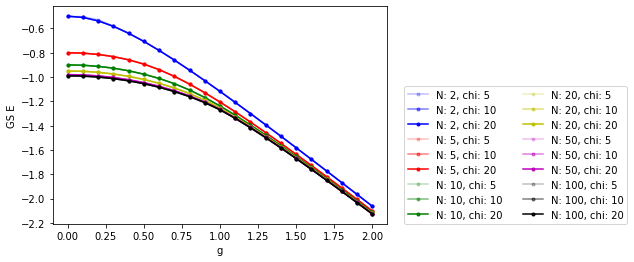

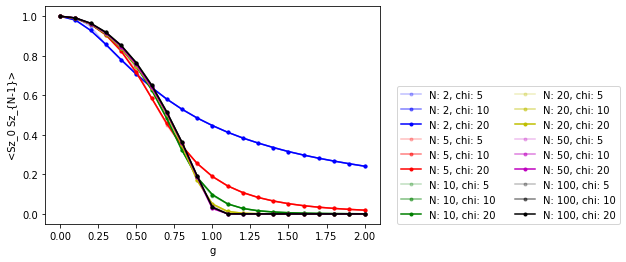

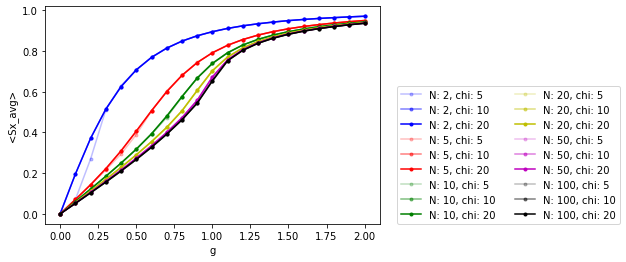

In [26]:
cols = ['b','r','g','y','m','k']
lc = len(cols)

for (data, ylabel) in [ (E, 'GS E'), (ZZ, '<Sz_0 Sz_{N-1}>'), (X,'<Sx_avg>') ]:
    f,a = plt.subplots()
    for N_idx, N in enumerate(Ns):
        for c_idx, chi in enumerate(bond_dims):
            label = 'N: '+str(N)+', chi: '+ str(chi)
            a.plot(gs, data[N_idx, c_idx], c=cols[N_idx%lc], linestyle = '-', marker='.', label = label, alpha = chi/max(bond_dims))
    a.set_xlabel('g')
    a.set_ylabel(ylabel)
    a.legend(loc = (1.05, 0), ncol=2)

This still takes a while to calculate, by N=10 it's already faster than exact diagonalization, and by N=100 the fact that it is even possible is a major success.

There are still some errors here that I have not dealt with carefully, coming from finite bond dimension (though this is minimal, as you can see in the figures it mostly makes no difference) and more importantly from the error that comes from having a finite $\tau$ in the algorithm.  With more computation time, you could use a smaller $\tau$ (by including ```imag_time_step_init = 10**-3``` as indicated above) while also increasing the max number of steps in the algorithm (```max_sweeps=2000```).